
# 🗳️ Lecture 9 – Data 100, Spring 2025

Data 100, Spring 2025

[Acknowledgments Page](https://ds100.org/sp25/acks/)

<img src="lit-digest-results.jpg" width="600">

The picture above shows the poll results printed in Literary Digest in 1936. You might think about how tedious it would be to tabulate 2.4 million responses and organize the results in this table **by hand**. We will use this data later in the demo.

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import zipfile

sns.set_theme(style='darkgrid', font_scale = 1.5,
              rc={'figure.figsize':(7,5)})

## 🇺🇸 1936 Presidential Election Results

Let's start with the real election results from the 1936 election.

* Each row of `votes` represents a single voter.
* `voted_dem` is 0/1 variable indicating whether the voter voted for Franklin D. Roosevelt, who was the Democratic candidate in 1936. If 0, the voter voted for Alf Landon, the Republican candidate.

Votes for other parties are excluded from this dataset.


In [5]:
# The large CSV containing all the votes is compressed to reduce storage size.
# This code unzips the file and reads the CSV into a pandas DataFrame.
# No need to be familiar with the unzipping code for Data 100!
with zipfile.ZipFile("1936_votes.zip", 'r') as z:
    with z.open("1936_votes.csv") as csv_file:
        votes = pd.read_csv(csv_file)

votes.head()

,voted_dem
0,1
1,1
2,0
3,1
4,1


How many votes were cast for either Roosevelt or Landon in 1936?

In [6]:
len(votes)

44430549

What fraction of voters voted for Roosevelt, the Democratic candidate?

In [7]:
votes['voted_dem'].sum() / len(votes)

np.float64(0.6245897614274358)

> But wait, don't the slides say that Roosevelt won 61% of the vote?
>
> Yes! But, he won 61% of **all** votes. If we filter to just the voters who
> voted for Roosevelt or Landon, Roosevelt won 62.5% of votes.

Useful tip: The mean of a 0/1 column is the same as the proportion of values that are 1.

In [8]:
votes['voted_dem'].mean()

np.float64(0.6245897614274358)

Of the **44,430,549** voters who voted for either Roosevelt or Landon, **62.5\%** voted for Roosevelt.

## 🎩 Simple Random Sample (SRS)

Note: An SRS is sometimes called a "names in a hat" sample, since it's a lot like putting each observation on a slip of paper, putting all the slips in a big hat, and then randomly drawing slips one at a time.

If we were to take a simple random sample of just 1,000 voters and calculate the proportion who planned to vote for Roosevelt, how close would we be to 62.5%?

In [9]:
votes['voted_dem'].sample(1000).mean()

np.float64(0.615)

Note that the cell above is a little slow, since we're sampling from a `DataFrame` with almost 45 million rows.

We can speed up the sampling using `NumPy`:

In [10]:
# Construct a random number generator object.
# No need to be familiar with using NumPy this way in Data 100!
rng = np.random.default_rng();

n_votes = len(votes)

# Generate 1000 random integers from 0 to (number of votes - 1)
idx = rng.integers(low=0, high=n_votes-1, size=1000)

votes['voted_dem'].iloc[idx].mean()

np.float64(0.65)

Both of the estimates above are pretty close to 62.5%! They are much closer than the estimate from the Literary Digest poll, which predicted that 43% of votes would go to Roosevelt.

This is no fluke! If we repeat this over and over, we tend to hover around 62.5%. 

In [11]:
for _ in range(10):
  idx = rng.integers(low=0, high=n_votes-1, size=1000)
  print(votes['voted_dem'].iloc[idx].mean())

0.635
0.639
0.613
0.58
0.64
0.651
0.607
0.643
0.609
0.597


Let's randomly generate 10,000 estimates:

In [12]:
nrep = 10000   # number of simulations
n = 1000       # size of our sample
results = []   # list to store the sampling results

for i in range(0, nrep):
    idx = rng.integers(low=0, high=n_votes, size=1000)
    results.append(votes['voted_dem'].iloc[idx].mean())

# First 10 simulated sample proportions
results[:10]

[np.float64(0.611),
 np.float64(0.632),
 np.float64(0.614),
 np.float64(0.608),
 np.float64(0.594),
 np.float64(0.613),
 np.float64(0.632),
 np.float64(0.61),
 np.float64(0.623),
 np.float64(0.639)]

Plotting our estimates with KDE:

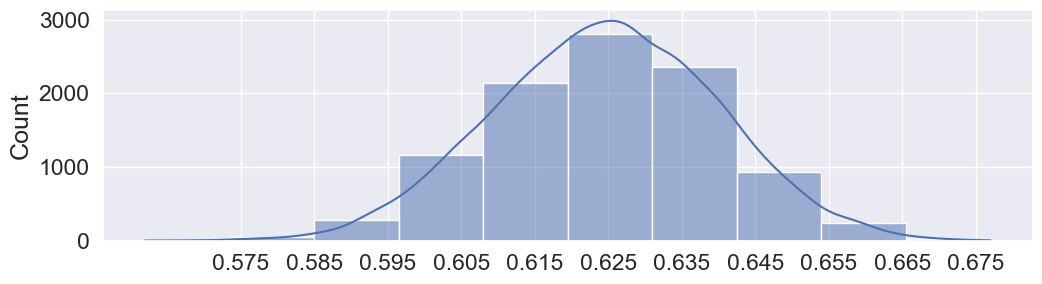

In [13]:
plt.figure(figsize=(12, 3))
p = sns.histplot(x=results, kde=True, bins=10)

# Make x-axis centered at 0.625 with 0.01 intervals
p.set_xticks(np.arange(0.625 - 5 * 0.01, 0.625 + 5 * 0.01, 0.01));

We get an approximate normal distribution centered around 62.5%, with most of the mass of the distribution (say, 95\% of the mass) within about 3 percentage points (0.03) on each side.

As it turns out, with a sample size of 1000, our estimate of the proportion of voters supporting Roosevelt has a margin of error of about 3 percentage points (3pp) at a 95\% confidence level (CL), so long as we take a simple random sample (SRS) of actual voters. 

- Note: You tend to see 3pp and 95% CL quite a lot in political polling! 

We'll learn what these values mean and how to calculate them when we (re)learn the Central Limit Theorem later in the semester.

<br><br>

**Instructor Note: Return to slides!**

## ⏪ Revisiting the 1936 Literary Digest Poll

The `poll` `DataFrame` contains a summary of the 1936 Literary Digest Poll, along with polling results and actual election results from 1932 and 1936.

* Each row of `poll` represents a U.S. state.
* `state`: name of the U.S. state.
* `electoral_votes`: # electoral votes allocated to the given state.
* `actual_dem_1936`: # votes for Roosevelt (the Democratic candidate) in 1936.
* `actual_rep_1936`: # votes for Landon (the Republican candidate) in 1936.
* `ld_dem_1936`: # Literary Digest respondents who planned to vote for Roosevelt in 1936.
* `ld_rep_1936`: # Literary Digest respondents who plannted to vote for Landon in 1936.

Literary Digest also had a 1932 poll! We will use this data for post-stratification:
* `actual_dem_1932`: # votes for the Democratic candidate in 1932.
* `actual_rep_1932`: # votes for the Republican candidate in 1932.
* `ld_dem_1932`: # of 1936 Literary Digest respondents who voted for the Democratic candidate in 1932.
* `ld_rep_1932`: # of 1936 Literary Digest respondents who voted for Republican candidate in 1932.

Note: Votes from parties other than Democratic and Republican are excluded from this dataset.

In [14]:
poll = pd.read_csv('literary-digest-summary-data.csv')
poll.head()

,state,electoral_votes,actual_dem_1936,actual_rep_1936,ld_rep_1936,ld_dem_1936,actual_dem_1932,actual_rep_1932,ld_dem_1932,ld_rep_1932
0,Alabama,11,238196,35358,3060,10082,207910,34675,9828,1589
1,Arizona,3,86722,33433,2337,1975,79264,36104,2202,1679
2,Arkansas,9,146765,32049,2724,7608,189602,28467,7608,1566
3,California,22,1766836,836431,89516,77245,1324157,847902,69720,80525
4,Colorado,6,295021,181267,15949,10025,250877,189617,9970,13619


As a sanity check, let's make sure we have the same number of votes as the first dataset (44,430,549):

In [15]:
poll['actual_dem_1936'].sum() + poll['actual_rep_1936'].sum()

np.int64(44430549)

Let's also check that we get the reported Literary Digest prediction of 43% for Roosevelt.

- Remember, Roosevelt received 62.5% of the actual vote.

In [16]:
poll['ld_dem_1936'].sum() / (poll['ld_dem_1936'].sum() + poll['ld_rep_1936'].sum())

np.float64(0.4289439704056572)

## 🥞 Post-stratification with Literary Digest responses from 1932 and 1936

Using **post-stratification**, let's see if we can improve the Literary Digest poll result using the **same information available to Literary Digest in 1936**. 

- In other words, without using data from the future!

Recall the steps of post-stratification:
1. Divide the sample and population into cells defined by chosen characteristics.
2. Calculate the overall response in each sample cell.
3. Aggregate over sample cells, reweighting by the size of the corresponding population cell.

**Sample**: Responses to the Literary Digest poll from 1932, among 1936 poll respondents

**Population**: The actual election outcomes in 1932

**Cells**: Every combination of state and political party

> Wait, aren't we interested in the 1936 Literary Digest poll?
> 
> - Yes! But, we can use responses from the older 1932 poll and 1932 election results to get our **sample cell weights**, and then use these weights to turn the 1936 poll results into a prediction of the 1936 election results.
>
> - Note that this approach assumes that over- and under-representation of voters among the poll respondents in state and party is the same in 1932 and 1936!

Let's start with step 1. We divide our population and sample into cells defined by each combination of **state** and **choice of party in 1932**:

- Cell 1: Alabama + Republican in 1932
- Cell 2: Alabama + Democratic in 1932
- Cell 3: Arizona + Republican in 1932
- Cell 4: Arizona + Democratic in 1932
- ...

> Note: Alaska and Hawaii were not U.S. states until after 1936.

The population cells are already in `polls`: `actual_dem_1932` and `actual_rep_1932` provide the actual vote counts for each party and state in 1932.

The sample cells are also in `polls`: `ld_dem_1932` and `ld_rep_1932` provide the number of responses to the 1932 Literary Digest poll, among 1936 poll respondents, for each party.

Let's make the **big** assumption that respondents in `ld_dem_1932` are representative of all voters in `actual_dem_1932` for each state, and the same for `ld_rep_1932` and `actual_rep_1932`.

- In other words, we claim that response rates and outreach for Democrats and Republicans from each state in 1932 can differ, but ultimately **poll respondents from a particular party+state combination are representative of actual voters for each party+state combination**.

- Then, we can calculate the **reweighting factor**, or how over- or under-represented poll respondents are relative to actual voters.

- All we need to do is divide the actual vote counts by the corresponding number of respondents, for each combination of party and state.

In [17]:
poll['dem_reweight_factor'] = poll['actual_dem_1932'] / poll['ld_dem_1932']
poll['rep_reweight_factor'] = poll['actual_rep_1932'] / poll['ld_rep_1932']
poll.tail()

,state,electoral_votes,actual_dem_1936,actual_rep_1936,ld_rep_1936,ld_dem_1936,actual_dem_1932,actual_rep_1932,ld_dem_1932,ld_rep_1932,dem_reweight_factor,rep_reweight_factor
43,Virginia,11,234980,98336,10223,16783,203979,89637,16194,6817,12.595961,13.149039
44,Washington,8,459579,206892,21370,15300,353260,208645,16223,17122,21.775257,12.185784
45,West Virginia,8,502582,325358,13660,10235,405124,330731,10818,11338,37.449066,29.170136
46,Wisconsin,12,802984,380828,33796,20781,707410,347741,24073,25731,29.386034,13.514477
47,Wyoming,3,62624,38739,2526,1533,54370,39583,1654,2072,32.871826,19.103764


Note that `dem_reweight_factor` is about 36 for Arizona.

- In other words, there were 36 times as many Democratic voters in Arizona than Democratic poll respondents.

Similarly, `rep_reweight_factor` is about 21.5 for Arizona.

- So, Democratic voters are **underrepresented** in the 1932 Literary Digest poll responses, relative to Republican voters.

- Based on the Republican bias in the Literary Digest sample discussed in lecture (i.e., wealthier folks with phones, cars, and magazines), this is expected!

Next, we apply these same weights to inflate the 1936 poll results into vote predictions.

- Again, note that this approach assumes over- and under-representation patterns are the same in the 1932 and 1936 polls!

In [18]:
poll['pred_dem_1936'] = round(poll['ld_dem_1936'] * poll['dem_reweight_factor'])
poll['pred_rep_1936'] = round(poll['ld_rep_1936'] * poll['rep_reweight_factor'])
poll.head()

,state,electoral_votes,actual_dem_1936,actual_rep_1936,ld_rep_1936,ld_dem_1936,actual_dem_1932,actual_rep_1932,ld_dem_1932,ld_rep_1932,dem_reweight_factor,rep_reweight_factor,pred_dem_1936,pred_rep_1936
0,Alabama,11,238196,35358,3060,10082,207910,34675,9828,1589,21.154864,21.821901,213283.0,66775.0
1,Arizona,3,86722,33433,2337,1975,79264,36104,2202,1679,35.996367,21.503276,71093.0,50253.0
2,Arkansas,9,146765,32049,2724,7608,189602,28467,7608,1566,24.921399,18.178161,189602.0,49517.0
3,California,22,1766836,836431,89516,77245,1324157,847902,69720,80525,18.992499,10.529674,1467076.0,942574.0
4,Colorado,6,295021,181267,15949,10025,250877,189617,9970,13619,25.163190,13.922975,252261.0,222058.0


Finally, let's calculate the proportion of **predicted** votes that are allocated to Roosevelt in 1936.

- Remember that Roosevelt received 62.5% of the **actual** vote in 1936. 

In [19]:
poll['pred_dem_1936'].sum() / (poll['pred_dem_1936'].sum() + poll['pred_rep_1936'].sum())

np.float64(0.5422251022375592)

54% is a majority! Using post-stratification, we have shifted the Literary Digest prediction of a Roosevelt loss with 43% of the vote to a (correct) Roosevelt win with 54%. 

- There is no cheating here; we used the same data available to Literary Digest in 1936.

- Note that post-stratification is not perfect. We are still off by almost 10 percentage points. But, we've moved in the right direction.

## 🎁 Bonus: Follow Up Improvements

As a follow-up exercise, we can compare the predicted 1936 vote totals to the actual 1932 vote totals.

- Then, we could apply a **correction factor** to change the predicted number of 1936 votes to be in line with the total number of votes in 1932.

- This exercise assumes that the total number of votes cast in 1932 would be the same in 1936, but the poll response rates and outreach might change between 1932 and 1936.

In [20]:
poll['pred_total_1936'] = poll['pred_dem_1936'] + poll['pred_rep_1936']
poll['actual_total_1932'] = poll['actual_dem_1932'] + poll['actual_rep_1932']
poll['correction_factor'] = poll['actual_total_1932'] / poll['pred_total_1936']
poll.head()

,state,electoral_votes,actual_dem_1936,actual_rep_1936,ld_rep_1936,ld_dem_1936,actual_dem_1932,actual_rep_1932,ld_dem_1932,ld_rep_1932,dem_reweight_factor,rep_reweight_factor,pred_dem_1936,pred_rep_1936,pred_total_1936,actual_total_1932,correction_factor
0,Alabama,11,238196,35358,3060,10082,207910,34675,9828,1589,21.154864,21.821901,213283.0,66775.0,280058.0,242585,0.866196
1,Arizona,3,86722,33433,2337,1975,79264,36104,2202,1679,35.996367,21.503276,71093.0,50253.0,121346.0,115368,0.950736
2,Arkansas,9,146765,32049,2724,7608,189602,28467,7608,1566,24.921399,18.178161,189602.0,49517.0,239119.0,218069,0.911969
3,California,22,1766836,836431,89516,77245,1324157,847902,69720,80525,18.992499,10.529674,1467076.0,942574.0,2409650.0,2172059,0.901400
4,Colorado,6,295021,181267,15949,10025,250877,189617,9970,13619,25.163190,13.922975,252261.0,222058.0,474319.0,440494,0.928687


In [21]:
poll['pred_dem_1936_corrected'] = poll['pred_dem_1936'] * poll['correction_factor']
poll['pred_rep_1936_corrected'] = poll['pred_rep_1936'] * poll['correction_factor']

poll['pred_dem_1936_corrected'].sum() / (poll['pred_dem_1936_corrected'].sum() + poll['pred_rep_1936_corrected'].sum())

np.float64(0.5419440974611633)

Looks like a pretty similar prediction for Roosevelt of 54%.

As it turns out, it looks like our original (i.e., uncorrected) predictions had a vote total closer to the true 1936 vote total:

In [22]:
print('Actual 1936 vote total:')
print(poll['actual_dem_1936'].sum() + poll['actual_rep_1936'].sum())

print('Predicted 1936 vote total, uncorrected:')
print(poll['pred_dem_1936'].sum() + poll['pred_rep_1936'].sum())

print('Predicted 1936 vote total, corrected:')
print(poll['pred_dem_1936_corrected'].sum() + poll['pred_rep_1936_corrected'].sum())


Actual 1936 vote total:
44430549
Predicted 1936 vote total, uncorrected:
42058418.0
Predicted 1936 vote total, corrected:
38582531.0


Furthermore, we can check whether post-stratification would have led to a predicted win for Roosevelt in the electoral college, which is what actually determines the election outcome. 

- To do this, we allocate **all** of the electoral votes in each state to the candidate with the most predicted votes in that state, and then sum up the total number of electoral votes allocated to each candidate across states. 

In [23]:
poll['dem_wins'] = poll['pred_dem_1936'] > poll['pred_rep_1936']

print('Total predicted Roosevelt electoral votes:')
print(( poll['dem_wins'] * poll['electoral_votes'] ).sum())

print('Total predicted Landon electoral votes:')
print(( (1-poll['dem_wins']) * poll['electoral_votes'] ).sum())

Total predicted Roosevelt electoral votes:
380
Total predicted Landon electoral votes:
151


We (correctly) predict a Roosevelt landslide in the electoral college!

- But, note that the actual electoral college landslide was much bigger: 523 to 8

- This is the largest electoral college landslide since 1820 (as of 2025).

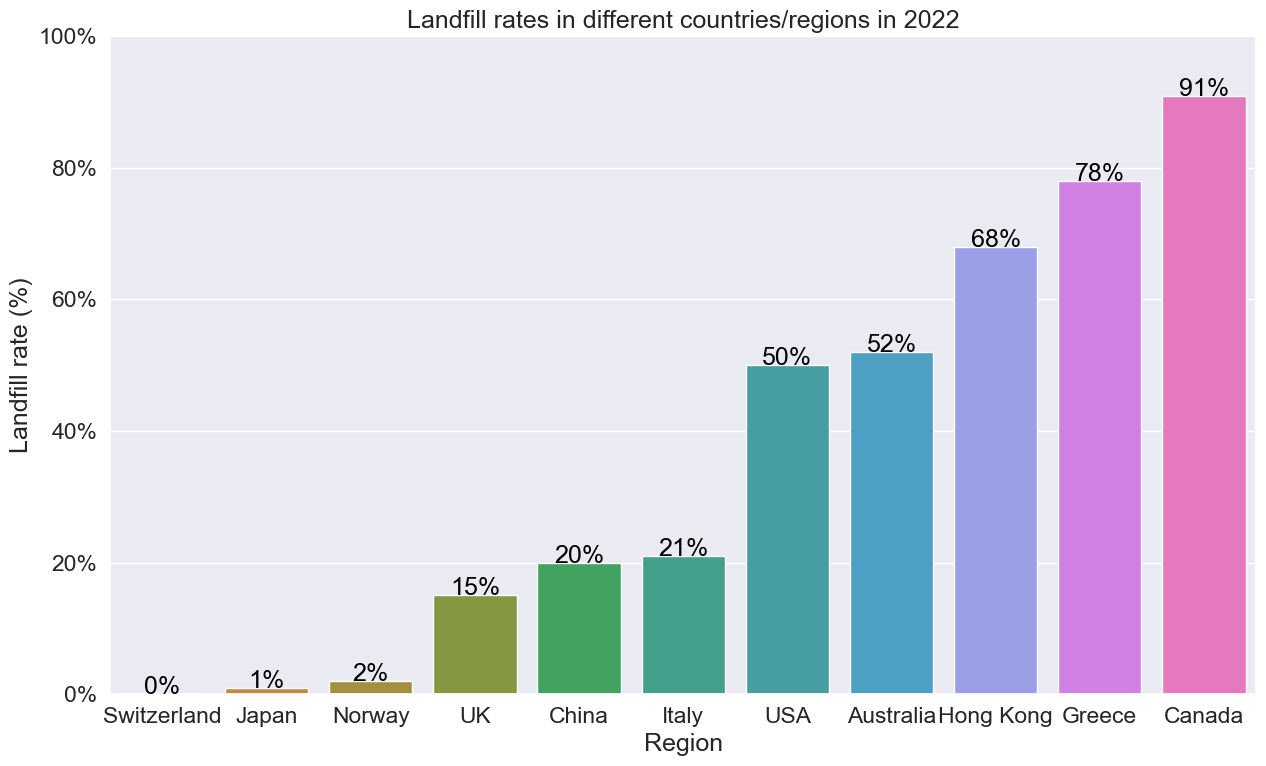

In [34]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

nations = pd.DataFrame({'Region': ['USA', 'Australia', 'UK', 'Hong Kong', 'Italy', 'Japan', 'Switzerland', 'Greece', 'Canada', 'China', 'Norway'],
                        'Landfill rate': [0.50, 0.52, 0.15, 0.68, 0.21, 0.01, 0.00, 0.78, 0.91, 0.20, 0.02]})
nations = nations.sort_values(by='Landfill rate').reset_index(drop=True)
plt.figure(figsize=(13, 8))
sns.barplot(data=nations, x='Region', y='Landfill rate',hue='Region')
plt.xlabel("Region")
plt.ylabel("Landfill rate (%)")
plt.title("Landfill rates in different countries/regions in 2022")
# Add numerical labels on top of the bars
for index, row in nations.iterrows():
    plt.text(index, row['Landfill rate'], f'{row["Landfill rate"]:.0%}',color='black', ha="center")
ticks,labels=plt.yticks()
plt.yticks([0,0.2,0.4,0.6,0.8,1],['0%','20%','40%','60%','80%','100%'])
plt.tight_layout()
plt.show()


Text(0.5, 1.0, 'Increased disease rate living near landfills')

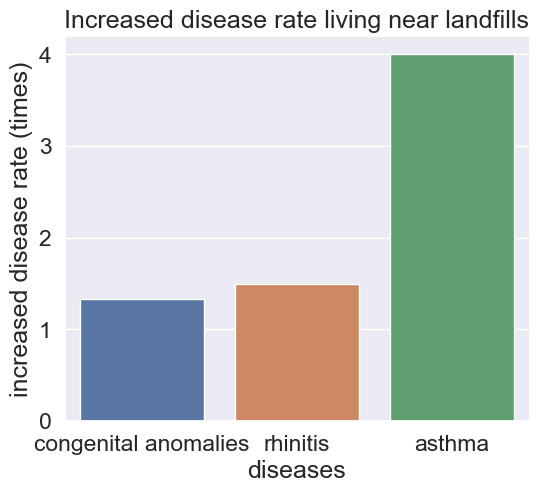

In [ ]:
diseases = pd.DataFrame({'diseases':['congenital anomalies','asthma','rhinitis'],'increased disease rate':[1.33,4,1.5]})
plt.figure(figsize=(6,5))
diseases = diseases.sort_values(by='increased disease rate').reset_index(drop=True)
sns.barplot(data=diseases,x=diseases['diseases'],y=diseases['increased disease rate'],hue='diseases')
plt.xlabel('diseases')
plt.ylabel('increased disease rate (times)')
plt.title('Increased disease rate living near landfills')